In [2]:
import os
import shutil

# Paths
root_dir = "/Users/spoorthivattem/Desktop/Roads/v1"   
output_images = "/Users/spoorthivattem/Desktop/Roads/Images"
output_masks = "/Users/spoorthivattem/Desktop/Roads/Masks"

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_masks, exist_ok=True)

# Go through all files in v1
for file in os.listdir(root_dir):
    file_path = os.path.join(root_dir, file)
    
    # Skip directories
    if os.path.isdir(file_path):
        continue

    # 1. Handle blank masks
    if file.endswith("_label_ground-truth.png"):
        print(f"Deleting blank mask: {file}")
        os.remove(file_path)
        continue

    # 2. Save valid masks
    if file.endswith("_label_ground-truth_coco-panoptic.png"):
        shutil.copy(file_path, os.path.join(output_masks, file))
        continue

    # 3. Save original images
    if file.endswith(".png") and "_label" not in file:
        shutil.copy(file_path, os.path.join(output_images, file))


Deleting blank mask: Selection_103_label_ground-truth.png
Deleting blank mask: Selection_070_label_ground-truth.png
Deleting blank mask: Selection_080_label_ground-truth.png
Deleting blank mask: Selection_041_label_ground-truth.png
Deleting blank mask: Selection_034_label_ground-truth.png
Deleting blank mask: Selection_077_label_ground-truth.png
Deleting blank mask: Selection_039_label_ground-truth.png
Deleting blank mask: Selection_087_label_ground-truth.png
Deleting blank mask: Selection_135_label_ground-truth.png
Deleting blank mask: Selection_046_label_ground-truth.png
Deleting blank mask: Selection_033_label_ground-truth.png
Deleting blank mask: Selection_074_label_ground-truth.png
Deleting blank mask: Selection_030_label_ground-truth.png
Deleting blank mask: Selection_045_label_ground-truth.png
Deleting blank mask: Selection_136_label_ground-truth.png
Deleting blank mask: Selection_079_label_ground-truth.png
Deleting blank mask: Selection_073_label_ground-truth.png
Deleting blank

In [4]:
from PIL import Image
import numpy as np
import os

mask_dir = "/Users/spoorthivattem/Desktop/Roads/Masks"
out_dir = "/Users/spoorthivattem/Desktop/Roads/B&W_maks"
os.makedirs(out_dir, exist_ok=True)

for mask_file in os.listdir(mask_dir):
    if not mask_file.endswith(".png"):
        continue

    path = os.path.join(mask_dir, mask_file)
    mask = np.array(Image.open(path))

    # Create binary mask: Blue -> 1, Black -> 0
    binary = np.where(mask[:, :, 2] > 128, 1, 0).astype(np.uint8)

    # Save as black & white mask (0 or 255)
    Image.fromarray(binary * 255).save(os.path.join(out_dir, mask_file))
    print('Done')


Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [5]:
# DeepLabV3 ResNet50 Semantic Segmentation - COMPLETE WORKING VERSION

import os, math, time, random, gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # reduce fragmentation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import functional as TF
from torchvision import transforms
from torchvision.models.segmentation import (
    deeplabv3_resnet50,
    DeepLabV3_ResNet50_Weights,
)
from torchvision.models import ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [16]:
# ---------------------------
# CONFIGURATION
# ---------------------------
DATA_DIR_IMAGES = "/Users/spoorthivattem/Desktop/Roads/Images"  # folder of images
DATA_DIR_MASKS = "/Users/spoorthivattem/Desktop/Roads/B&W_maks"   # folder of masks
IMG_EXTS = {".jpg", ".jpeg", ".png"}  # allowed image extensions
MASK_EXTS = {".png", ".jpg"}  # allowed mask extensions

IMAGE_SIZE = 256  # keep 256 on T4 for ResNet50
BATCH_SIZE = 2    # 1 or 2 on T4; increase only if you have spare VRAM
EPOCHS = 20
LEARNING_RATE = 3e-4
VAL_SPLIT = 0.15
NUM_WORKERS = 0   # Set to 0 to avoid multiprocessing issues
SEED = 42

import os

CHECKPOINT_DIR = "./checkpoints"   # local folder in current project
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")

In [11]:
# ---------------------------
# SETUP
# ---------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    free, total = torch.cuda.mem_get_info()
    print(f"CUDA: {torch.cuda.get_device_name(0)} | Free: {free/1e9:.2f} GB / {total/1e9:.2f} GB")

In [12]:
import os

def list_pairs(img_dir, mask_dir):
    imgs = []

    for img_file in sorted(os.listdir(img_dir)):
        if not img_file.endswith(".png"):
            continue

        # Remove extension
        base = os.path.splitext(img_file)[0]

        # Find matching mask using startswith
        matching_masks = [
            m for m in os.listdir(mask_dir)
            if m.startswith(base) and m.endswith("_label_ground-truth_coco-panoptic.png")
        ]

        if matching_masks:
            mask_file = matching_masks[0]
            imgs.append((os.path.join(img_dir, img_file),
                         os.path.join(mask_dir, mask_file)))

    if not imgs:
        raise RuntimeError(
            f"No (image, mask) pairs found.\nCheck:\n  Images: {img_dir}\n  Masks: {mask_dir}"
        )
    return imgs


In [13]:
# ---------------------------
# DATASET CLASS (COMPLETELY FIXED)
# ---------------------------
class SegDataset(Dataset):
    def __init__(self, pairs, image_size=256, train=True):
        self.pairs = pairs
        self.image_size = image_size
        self.train = train

        # FIXED: Added ToTensor() before ConvertImageDtype
        self.img_transform = transforms.Compose([
            transforms.Resize((image_size, image_size),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            antialias=True),
            transforms.ToTensor(),  # CRITICAL: Convert PIL to tensor FIRST
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
        ])

        # FIXED: Added ToTensor() for masks too
        self.mask_transform = transforms.Compose([
            transforms.Resize((image_size, image_size),
                            interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),  # CRITICAL: Convert PIL to tensor FIRST
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        # Load as PIL Images
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Optional simple augments for train
        if self.train:
            if random.random() < 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
            if random.random() < 0.2:
                img = TF.adjust_brightness(img, 0.9 + 0.2*random.random())

        # Apply transforms (now properly converts PIL -> tensor)
        img = self.img_transform(img)
        mask = self.mask_transform(mask)

        # Convert mask to binary {0,1}
        mask = (mask > 0.5).float()

        return img, mask

In [17]:
print(DATA_DIR_IMAGES)
print(DATA_DIR_MASKS)

/Users/spoorthivattem/Desktop/Roads/Images
/Users/spoorthivattem/Desktop/Roads/B&W_maks


In [18]:
# ---------------------------
# DATA LOADERS (FIXED)
# ---------------------------
all_pairs = list_pairs(DATA_DIR_IMAGES, DATA_DIR_MASKS)
random.shuffle(all_pairs)
n_val = max(1, int(len(all_pairs) * VAL_SPLIT))
val_pairs = all_pairs[:n_val]
train_pairs = all_pairs[n_val:]

train_ds = SegDataset(train_pairs, image_size=IMAGE_SIZE, train=True)
val_ds = SegDataset(val_pairs, image_size=IMAGE_SIZE, train=False)

# FIXED: Added drop_last=True to prevent BatchNorm errors
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=True,
                         persistent_workers=(NUM_WORKERS>0),
                         drop_last=True)  # CRITICAL: Prevents batch size = 1 errors

val_loader = DataLoader(val_ds, batch_size=1, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=True,
                       persistent_workers=(NUM_WORKERS>0))

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Image size: {IMAGE_SIZE} | Batch size: {BATCH_SIZE}")

Train: 83 | Val: 14 | Image size: 256 | Batch size: 2


In [19]:
# ---------------------------
# MODEL SETUP
# ---------------------------
# Use ResNet50 backbone weights
weights_backbone = ResNet50_Weights.IMAGENET1K_V1
model = deeplabv3_resnet50(weights=None, weights_backbone=weights_backbone, num_classes=1)
model = model.to(device)

# Loss + Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Mixed precision scaler (FIXED: Updated to new API)
scaler = torch.amp.GradScaler('cuda', enabled=(device.type == "cuda"))

In [20]:
# ---------------------------
# METRICS
# ---------------------------
@torch.no_grad()
def compute_iou(pred, target, eps=1e-7):
    # pred, target: (N,1,H,W) in {0,1}
    inter = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred*target).sum(dim=(1,2,3)) + eps
    return (inter / union).mean().item()

@torch.no_grad()
def compute_dice(pred, target, eps=1e-7):
    inter = (pred * target).sum(dim=(1,2,3))
    denom = (pred + target).sum(dim=(1,2,3)) + eps
    return (2*inter / denom).mean().item()

In [21]:
# ---------------------------
# TRAIN / EVAL LOOPS (FIXED)
# ---------------------------
def train_one_epoch(epoch):
    model.train()
    torch.cuda.empty_cache()
    running = 0.0
    t0 = time.time()

    for imgs, masks in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        # SAFETY CHECK: Skip if somehow batch size is still 1
        if imgs.size(0) == 1:
            print(f"Skipping batch with size 1 in epoch {epoch}")
            continue

        optimizer.zero_grad(set_to_none=True)
        # FIXED: Updated autocast API
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            out = model(imgs)["out"]  # (N,1,H,W) logits
            loss = criterion(out, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)

    return running / len(train_loader.dataset), time.time()-t0

@torch.no_grad()
def evaluate():
    model.eval()
    loss_sum = 0.0
    iou_sum = 0.0
    dice_sum = 0.0
    count = 0

    for imgs, masks in val_loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        # FIXED: Updated autocast API
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            out = model(imgs)["out"]
            loss = criterion(out, masks)

        probs = torch.sigmoid(out)
        preds = (probs > 0.5).float()

        loss_sum += loss.item()
        iou_sum += compute_iou(preds, masks)
        dice_sum += compute_dice(preds, masks)
        count += 1

    return loss_sum / max(1,count), iou_sum / max(1,count), dice_sum / max(1,count)

In [22]:
# ---------------------------
# CHECKPOINT UTILITIES
# ---------------------------
def save_ckpt(path):
    torch.save({"model": model.state_dict(),
                "opt": optimizer.state_dict(),
                "scaler": scaler.state_dict()}, path)
    print(f"Checkpoint saved to {path}")

def load_ckpt(path):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["opt"])
    scaler.load_state_dict(ckpt["scaler"])
    print(f"Checkpoint loaded from {path}")


In [23]:
# ---------------------------
# TRAINING LOOP (COMPLETE & ROBUST)
# ---------------------------
print("Starting training...")
print(f"Total training samples: {len(train_ds)}")
print(f"Total validation samples: {len(val_ds)}")
print(f"Batches per epoch: {len(train_loader)}")

train_losses = []
val_losses = []
val_ious = []
val_dices = []
best_val = math.inf

for epoch in range(1, EPOCHS+1):
    try:
        # Train for one epoch
        tr_loss, tr_time = train_one_epoch(epoch)
        train_losses.append(tr_loss)

        # Evaluate
        val_loss, val_iou, val_dice = evaluate()
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_dices.append(val_dice)

        print(f"[{epoch:03d}/{EPOCHS}] "
              f"train_loss={tr_loss:.4f} ({tr_time:.1f}s) | "
              f"val_loss={val_loss:.4f} IoU={val_iou:.4f} Dice={val_dice:.4f}")

        # Save best checkpoint
        if val_loss < best_val:
            best_val = val_loss
            save_ckpt(CHECKPOINT_PATH)
            print(f"🎉 New best model! Val Loss: {val_loss:.4f}")

        # Memory cleanup every few epochs
        if epoch % 5 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    except Exception as e:
        print(f"❌ Error in epoch {epoch}: {e}")
        import traceback
        traceback.print_exc()

        # Try to continue training
        torch.cuda.empty_cache()
        gc.collect()
        continue

# Load best model
if os.path.isfile(CHECKPOINT_PATH):
    load_ckpt(CHECKPOINT_PATH)
    model.eval()
    print(f"✅ Loaded best checkpoint")
else:
    print("⚠️ No checkpoint found, using current model state")

Starting training...
Total training samples: 83
Total validation samples: 14
Batches per epoch: 41
[001/20] train_loss=0.5320 (46.1s) | val_loss=0.5410 IoU=0.1124 Dice=0.1971
Checkpoint saved to ./checkpoints/best_model.pth
🎉 New best model! Val Loss: 0.5410
[002/20] train_loss=0.3892 (46.9s) | val_loss=0.4001 IoU=0.2120 Dice=0.3337
Checkpoint saved to ./checkpoints/best_model.pth
🎉 New best model! Val Loss: 0.4001
[003/20] train_loss=0.3346 (49.3s) | val_loss=0.3610 IoU=0.2592 Dice=0.3891
Checkpoint saved to ./checkpoints/best_model.pth
🎉 New best model! Val Loss: 0.3610
[004/20] train_loss=0.3038 (49.6s) | val_loss=0.3503 IoU=0.2756 Dice=0.4131
Checkpoint saved to ./checkpoints/best_model.pth
🎉 New best model! Val Loss: 0.3503
[005/20] train_loss=0.2916 (53.8s) | val_loss=0.3437 IoU=0.3423 Dice=0.4963
Checkpoint saved to ./checkpoints/best_model.pth
🎉 New best model! Val Loss: 0.3437
[006/20] train_loss=0.2743 (56.1s) | val_loss=0.3400 IoU=0.2709 Dice=0.4117
Checkpoint saved to ./che

/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_5211/1353628130.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


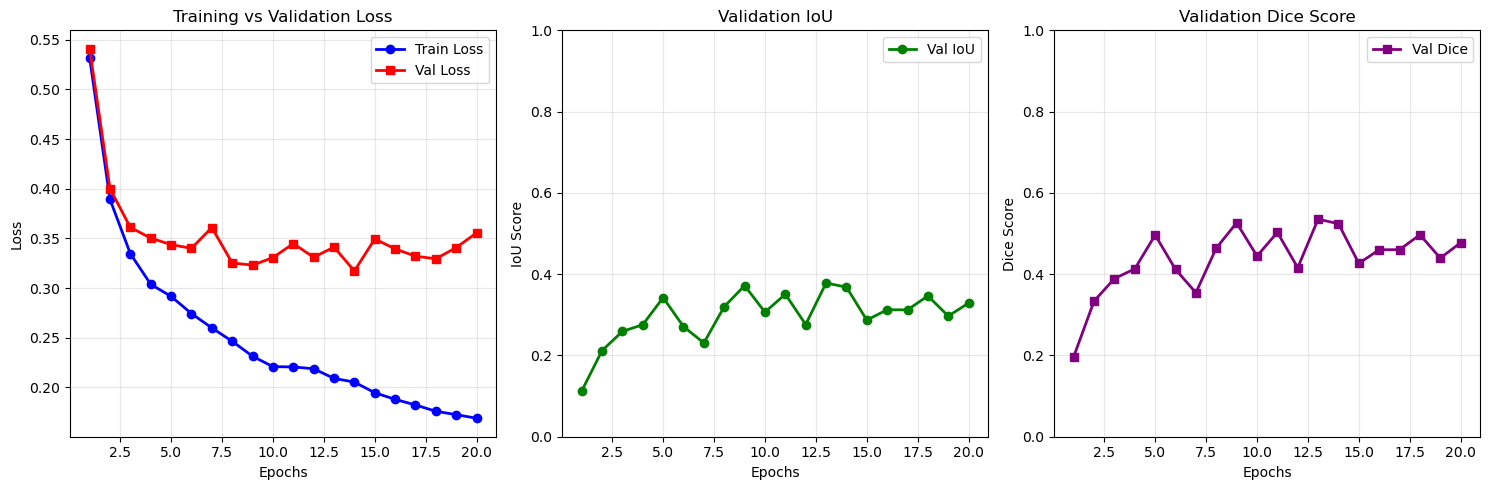


📊 FINAL RESULTS:
Best validation loss: 0.3172
Final validation IoU: 0.3289
Final validation Dice: 0.4774
Max validation IoU: 0.3782
Max validation Dice: 0.5353


In [24]:
# ---------------------------
# RESULTS VISUALIZATION
# ---------------------------
if len(train_losses) > 0:
    plt.figure(figsize=(15, 5))

    # Plot 1: Losses
    plt.subplot(1, 3, 1)
    epochs_range = range(1, len(train_losses)+1)
    plt.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, val_losses, 'r-s', label='Val Loss', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, val_ious, 'g-o', label='Val IoU', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("IoU Score")
    plt.title("Validation IoU")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1])

    # Plot 3: Dice
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, val_dices, 'purple', marker='s', label='Val Dice', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Dice Score")
    plt.title("Validation Dice Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print(f"\n📊 FINAL RESULTS:")
    print(f"Best validation loss: {best_val:.4f}")
    print(f"Final validation IoU: {val_ious[-1]:.4f}")
    print(f"Final validation Dice: {val_dices[-1]:.4f}")
    print(f"Max validation IoU: {max(val_ious):.4f}")
    print(f"Max validation Dice: {max(val_dices):.4f}")



🖼️ Visualizing 3 sample predictions...


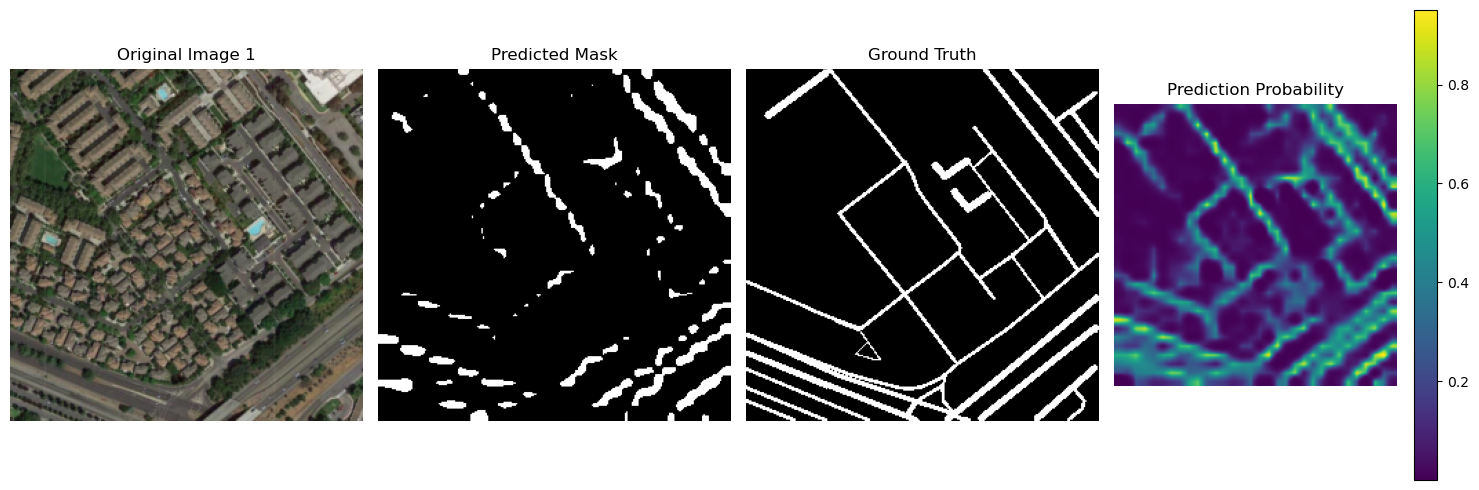

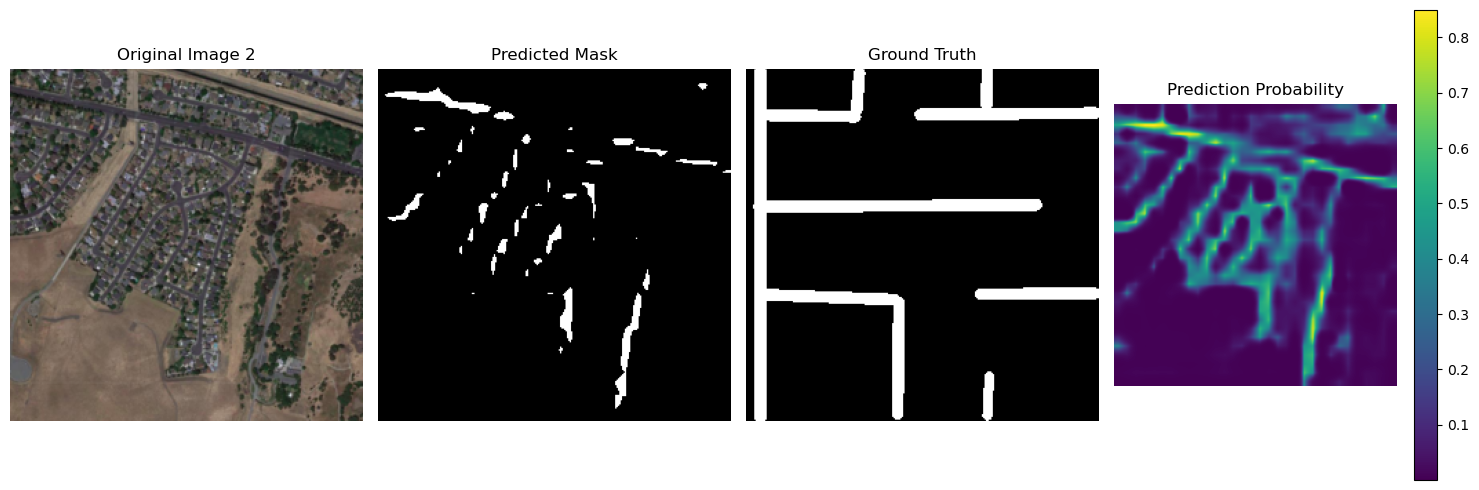

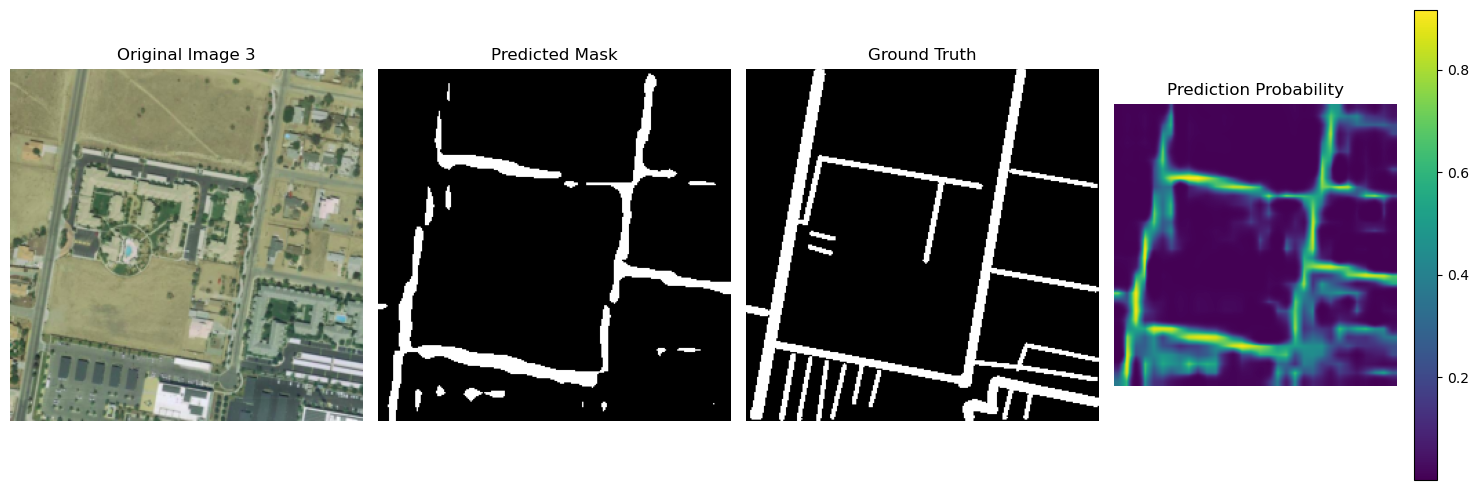


🎉 Training completed successfully!
Model saved at: ./checkpoints/best_model.pth
You can now use the trained model for inference!


In [25]:
# ---------------------------
# SAMPLE PREDICTIONS VISUALIZATION (FIXED)
# ---------------------------
def visualize_samples(num_samples=3):
    """Visualize sample predictions"""
    model.eval()
    samples = random.sample(val_pairs if len(val_pairs)>=num_samples else train_pairs,
                           k=min(num_samples, len(all_pairs)))

    print(f"\n🖼️ Visualizing {len(samples)} sample predictions...")

    for i, (img_path, mask_path) in enumerate(samples):
        # Load raw images
        raw_img = Image.open(img_path).convert("RGB")
        raw_mask = Image.open(mask_path).convert("L")

        # FIXED: Proper transform pipeline matching dataset
        img_tensor = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            antialias=True),
            transforms.ToTensor(),  # CRITICAL: Convert to tensor first
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])(raw_img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():  # ✅ ADDED: Disable gradients for inference
            with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
                logits = model(img_tensor)["out"]

        # ✅ FIXED: Added .detach() before .cpu().numpy()
        prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()  # H,W
        pred_mask_01 = (prob > 0.5).astype(np.uint8)*255

        # Resize for display
        disp_img = raw_img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
        disp_gt = raw_mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)
        disp_pred = Image.fromarray(pred_mask_01).resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

        # Plot
        plt.figure(figsize=(15, 5))



        plt.subplot(1, 4, 1)
        plt.imshow(disp_img)
        plt.title(f"Original Image {i+1}")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(disp_pred, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(disp_gt, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(prob, cmap="viridis")
        plt.title("Prediction Probability")
        plt.colorbar()
        plt.axis("off")



        plt.tight_layout()
        plt.show()

# Show sample predictions
visualize_samples(num_samples=3)

print(f"\n🎉 Training completed successfully!")
print(f"Model saved at: {CHECKPOINT_PATH}")
print(f"You can now use the trained model for inference!")



🖼️ Visualizing 3 sample predictions...


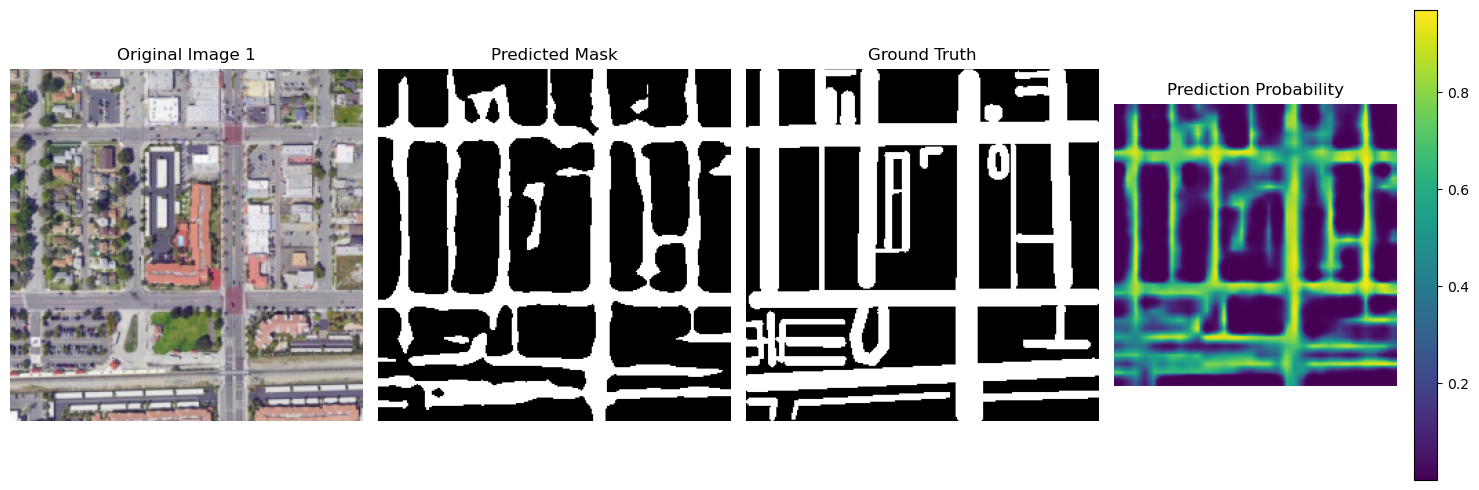

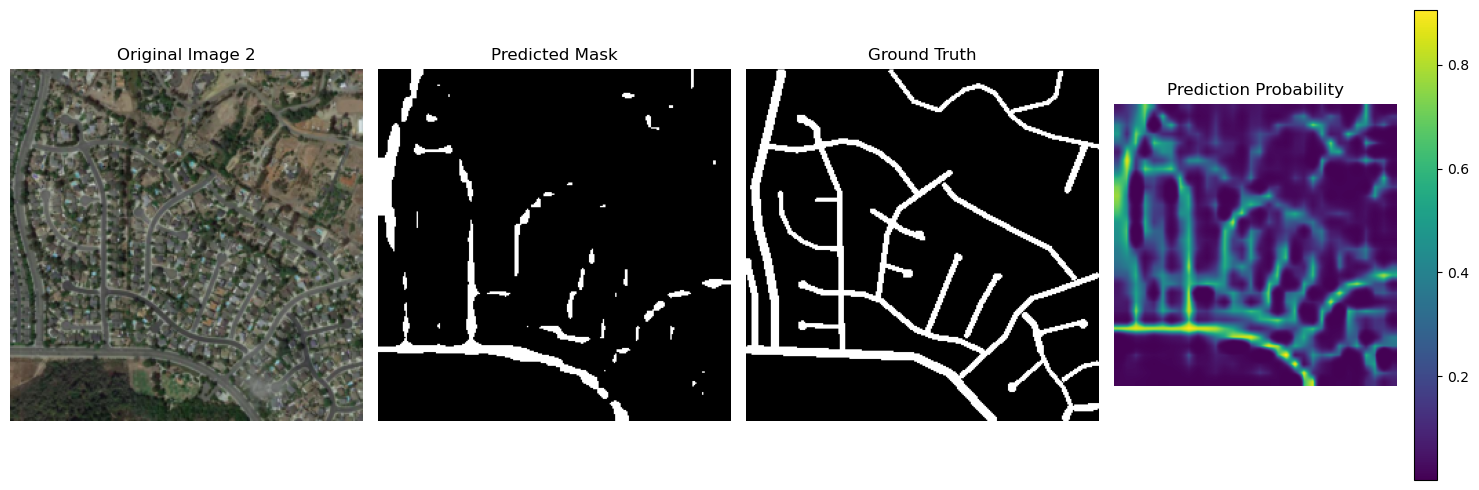

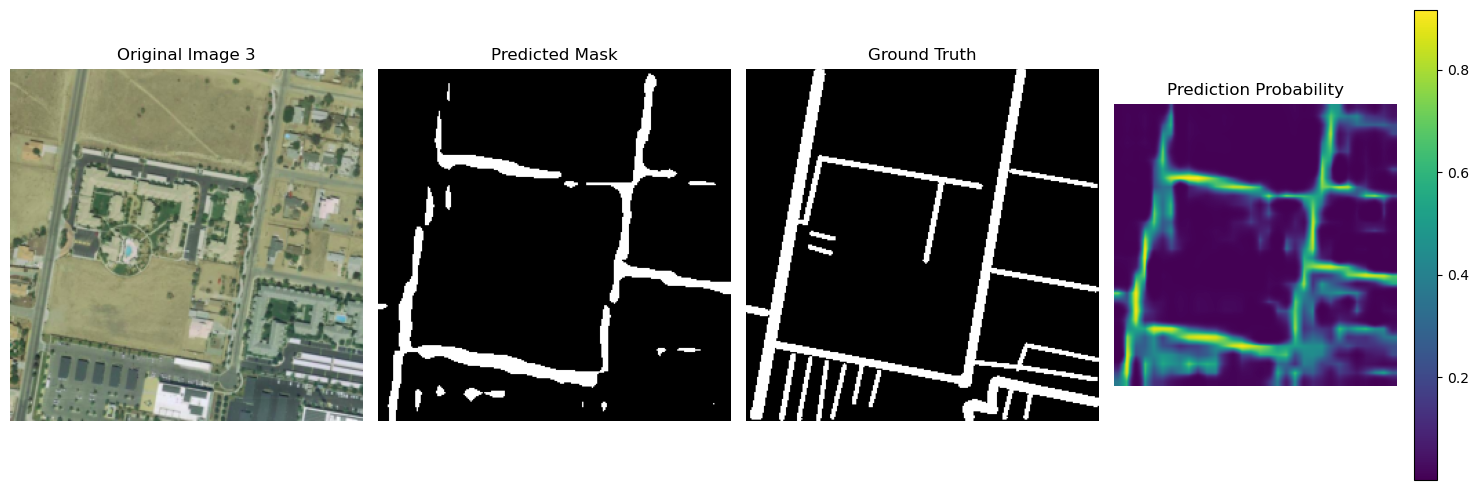


🎉 Training completed successfully!
Model saved at: ./checkpoints/best_model.pth
You can now use the trained model for inference!


In [26]:
# ---------------------------
# SAMPLE PREDICTIONS VISUALIZATION (FIXED)
# ---------------------------
def visualize_samples(num_samples=3):
    """Visualize sample predictions"""
    model.eval()
    samples = random.sample(val_pairs if len(val_pairs)>=num_samples else train_pairs,
                           k=min(num_samples, len(all_pairs)))

    print(f"\n🖼️ Visualizing {len(samples)} sample predictions...")

    for i, (img_path, mask_path) in enumerate(samples):
        # Load raw images
        raw_img = Image.open(img_path).convert("RGB")
        raw_mask = Image.open(mask_path).convert("L")

        # FIXED: Proper transform pipeline matching dataset
        img_tensor = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            antialias=True),
            transforms.ToTensor(),  # CRITICAL: Convert to tensor first
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])(raw_img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():  # ✅ ADDED: Disable gradients for inference
            with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
                logits = model(img_tensor)["out"]

        # ✅ FIXED: Added .detach() before .cpu().numpy()
        prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()  # H,W
        pred_mask_01 = (prob > 0.5).astype(np.uint8)*255

        # Resize for display
        disp_img = raw_img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
        disp_gt = raw_mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)
        disp_pred = Image.fromarray(pred_mask_01).resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

        # Plot
        plt.figure(figsize=(15, 5))



        plt.subplot(1, 4, 1)
        plt.imshow(disp_img)
        plt.title(f"Original Image {i+1}")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(disp_pred, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(disp_gt, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(prob, cmap="viridis")
        plt.title("Prediction Probability")
        plt.colorbar()
        plt.axis("off")



        plt.tight_layout()
        plt.show()

# Show sample predictions
visualize_samples(num_samples=3)

print(f"\n🎉 Training completed successfully!")
print(f"Model saved at: {CHECKPOINT_PATH}")
print(f"You can now use the trained model for inference!")



🖼️ Visualizing 20 sample predictions...


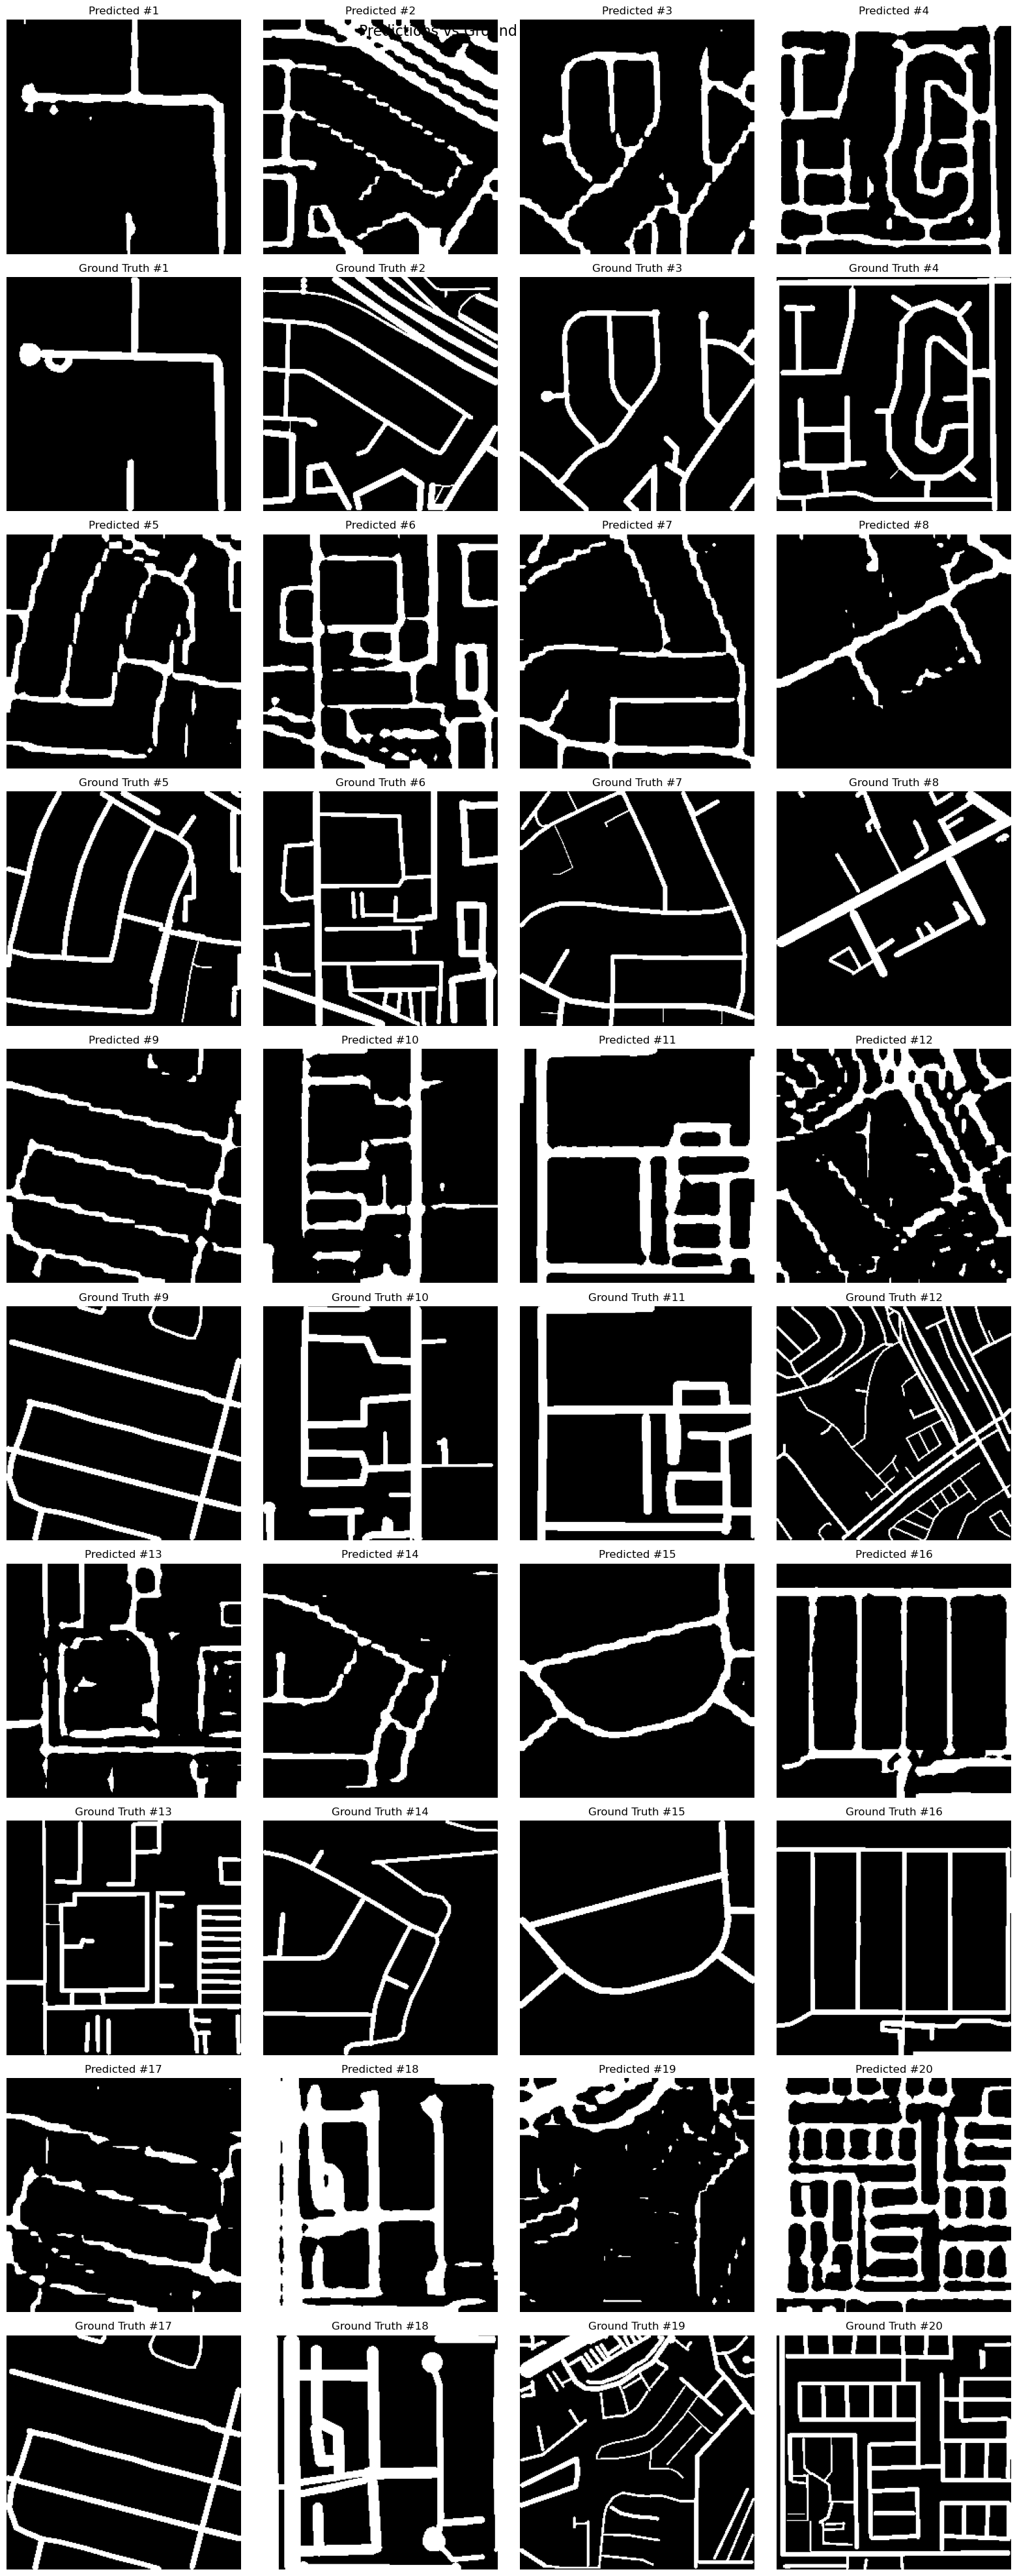

In [27]:
# ---------------------------
# CORRECT APPROACH - VISUALIZE 20 SAMPLES
# ---------------------------
def visualize_samples(num_samples=20):
    """Visualize sample predictions"""
    model.eval()
    samples = random.sample(val_pairs if len(val_pairs)>=num_samples else train_pairs,
                           k=min(num_samples, len(all_pairs)))

    print(f"\n🖼️ Visualizing {len(samples)} sample predictions...")

    # Create grid layout for 20 samples (4 columns, 5 rows for predictions + ground truth)
    fig, axes = plt.subplots(10, 4, figsize=(16, 40))  # 10 rows (5 for pred, 5 for GT), 4 columns

    for i, (img_path, mask_path) in enumerate(samples):
        # Load raw images
        raw_img = Image.open(img_path).convert("RGB")
        raw_mask = Image.open(mask_path).convert("L")

        # Transform pipeline
        img_tensor = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            antialias=True),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])(raw_img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
                logits = model(img_tensor)["out"]

        prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()
        pred_mask_01 = (prob > 0.5).astype(np.uint8)*255

        # Resize for display
        disp_gt = raw_mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)
        disp_pred = Image.fromarray(pred_mask_01).resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

        # Calculate positions in grid
        row = i // 4  # Which set of 4 samples
        col = i % 4   # Which column in the set

        # Top half: Predicted masks
        axes[row * 2, col].imshow(disp_pred, cmap="gray")
        axes[row * 2, col].set_title(f"Predicted #{i+1}")
        axes[row * 2, col].axis("off")

        # Bottom half: Ground truth masks
        axes[row * 2 + 1, col].imshow(disp_gt, cmap="gray")
        axes[row * 2 + 1, col].set_title(f"Ground Truth #{i+1}")
        axes[row * 2 + 1, col].axis("off")

    plt.suptitle("Predictions vs Ground Truth - 20 Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 20 samples
visualize_samples(num_samples=20)
